<br><br>

## **Import necessary Python libraries and modules**

In [ ]:
from collections import defaultdict
import json
import random
import re

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import torch

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 2.3MB 30.0MB/s 
     |████████████████████████████████| 901kB 37.0MB/s 
     |████████████████████████████████| 3.3MB 52.2MB/s 


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

<br><br>

## **Set parameters and file paths**

In [ ]:
# This is the name of the BERT model that we want to use. We're using DistilBERT to save space (it's a distilled version of the full BERT model), and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'  

 # This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'       

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# This is the name of the directory where we'll save our model.
cached_model_directory_name = 'distilbert-birth-control-reddit'  

<br><br>

## **Load and sample labeled Reddit data**

In [ ]:
labeled_df = pd.read_csv('final_labeled_df.csv')
labeled_df = labeled_df[labeled_df['Source'] == 'twitter-replies']

In [ ]:
len(labeled_df)

296

In [ ]:
labeled_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,ID,Label,Text,Source,Decision,Type,Tokens
1205,315,315,1133797249375395800,PROVIDING EXPERIENCES,@EmBaer Got my IUD in Nov 2016.,twitter-replies,two or more,IUD,NaN
1086,186,186,1090397774296830000,PROVIDING EXPERIENCES,@faithmoroness My sister got pregnant on birth...,twitter-replies,two or more,IUD,NaN
1015,98,98,1169519903755448300,PROVIDING EXPERIENCES,@BWiseHealth I am on the implanon nxt. I love ...,twitter-replies,two or more,Implant,NaN


In [ ]:
labeled_df['Label'].value_counts()

PROVIDING EXPERIENCES              134
DISCOURSE                           79
PROVIDING INFORMATIONAL SUPPORT     58
SEEKING INFORMATIONAL SUPPORT       10
SEEKING EMOTIONAL SUPPORT            8
PROVIDING EMOTIONAL SUPPORT          5
SEEKING EXPERIENCES                  2
Name: Label, dtype: int64

<br><br>

# **One label classification**

## **Filter and balance the data for a single label**

In [ ]:
target_label = 'DISCOURSE'

In [ ]:
reddit_df_positive = labeled_df[labeled_df['Label'] == target_label]
reddit_df_positive['Target Label'] = reddit_df_positive['Label']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
len(reddit_df_positive.index)

79

In [ ]:
reddit_df_positive.sample(3)

,Unnamed: 0,Unnamed: 0.1,ID,Label,Text,Source,Decision,Type,Tokens,Target Label
1135,240,240,1085297295355109400,DISCOURSE,@apihtawikosisan lmao i fucking wish. someone ...,twitter-replies,two or more,IUD,NaN,DISCOURSE
983,57,57,1309676603652399000,DISCOURSE,@LeaverBeee @DrJenGunter I destroyed more unde...,twitter-replies,two or more,IUD,NaN,DISCOURSE
981,55,55,506864575967289340,DISCOURSE,Pay my student loans. “@AsaAkira: Cum in my pu...,twitter-replies,two or more,Pill,NaN,DISCOURSE


In [ ]:
reddit_df_negative = labeled_df[labeled_df['Label'] != target_label]
reddit_df_negative = reddit_df_negative[~reddit_df_negative['ID'].isin(reddit_df_positive['ID'].tolist())]
reddit_df_negative['Target Label'] = ['NOT ' + target_label]*len(reddit_df_negative.index)

In [ ]:
len(reddit_df_negative.index)

195

In [ ]:
reddit_df_negative.sample(3)

,Unnamed: 0,Unnamed: 0.1,ID,Label,Text,Source,Decision,Type,Tokens,Target Label
1013,96,96,1225092146312700000,PROVIDING EXPERIENCES,@Cass_eroll i have IUD now! i did have the nex...,twitter-replies,two or more,IUD,NaN,NOT DISCOURSE
1220,330,330,910893889644634100,PROVIDING EXPERIENCES,@megobits Ooh yeah I noticed that in myself an...,twitter-replies,two or more,IUD,NaN,NOT DISCOURSE
1038,126,126,1216176663630942200,PROVIDING EXPERIENCES,@zibukins @sindivanzyl I have the IUD removed ...,twitter-replies,two or more,IUD,NaN,NOT DISCOURSE


In [ ]:
reddit_df_combined = pd.concat([reddit_df_negative.sample(len(reddit_df_positive.index)), reddit_df_positive])

In [ ]:
len(reddit_df_combined.index)

158

In [ ]:
reddit_df_combined.sample(3)

,Unnamed: 0,Unnamed: 0.1,ID,Label,Text,Source,Decision,Type,Tokens,Target Label
1006,88,88,1288128202687144000,DISCOURSE,@AmazingE__ Just don’t get no IUD ... shit jus...,twitter-replies,two or more,IUD,NaN,DISCOURSE
1049,137,137,1120536948978921500,DISCOURSE,@jkwillettmd No way would I let that gyn dilat...,twitter-replies,two or more,IUD,NaN,DISCOURSE
1061,153,153,1330883260419858400,PROVIDING INFORMATIONAL SUPPORT,@ultratcha What about catching HIV OR Syphilis...,twitter-replies,two or more,Implant,NaN,NOT DISCOURSE


In [ ]:
reddit_df_combined['Target Label'].value_counts()

DISCOURSE        79
NOT DISCOURSE    79
Name: Target Label, dtype: int64

In [ ]:
reddit_df_combined['Target Label'].value_counts(normalize=True)

DISCOURSE        0.5
NOT DISCOURSE    0.5
Name: Target Label, dtype: float64

In [ ]:
def get_text(text):
  if len(text.split()) < 512:
    return text
  title = re.findall(r'[[TITLE:].+]', text)[0]
  title_length = 512 - len(title.split())
  text_without_title = text.split(']')[1]
  new_text = title + ' ' + ' '.join(text_without_title.split()[-title_length:])
  return new_text


reddit_df_combined = reddit_df_combined.sample(frac=1)

all_texts = reddit_df_combined['Text'].tolist()
all_texts = [get_text(t) for t in all_texts] # Optionally do the truncation here (and take the last 500 tokens)
all_labels = reddit_df_combined['Target Label'].tolist()

train_texts = all_texts[:100]
train_labels = all_labels[:100]

test_texts = all_texts[100:]
test_labels = all_labels[100:]

In [ ]:
for t in all_texts:
  assert len(t.split()) <= 512

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(100, 100, 58, 58)

<br><br>

## **Run a baseline model (Logistic Regression)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [ ]:
len(train_labels), X_train.shape

(100, (100, 930))

In [ ]:
model = LogisticRegression(C=5).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [ ]:
print(classification_report(test_labels, predictions))

               precision    recall  f1-score   support

    DISCOURSE       0.83      0.59      0.69        32
NOT DISCOURSE       0.63      0.85      0.72        26

     accuracy                           0.71        58
    macro avg       0.73      0.72      0.71        58
 weighted avg       0.74      0.71      0.70        58



<br><br>

## **Encode data for BERT**

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

In [ ]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['NOT DISCOURSE', 'DISCOURSE'])

In [ ]:
id2label.keys()

dict_keys([0, 1])

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

'[CLS] Up ##date : i got an i ##ud , another update my c ##ram ##ps are horrible [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

"[CLS] @ B ##W ##ise ##H ##eal ##th I am on the imp ##lan ##on n ##x ##t . I love it because I will take it out in 3 ##yr ##s time . it saves me transport money for going to the clinic . I love it cause It has reduced my period flow & am ##p ; period pains . It wasn ' t painful when it was inserted & am ##p ; my arm doesn ' t feel weird as I thought it would [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
set(train_labels_encoded)

{0, 1}

In [ ]:
set(test_labels_encoded)

{0, 1}

<br><br>

## **Make a custom Torch dataset**

Here we use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
        

train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] Up ##date : i got an i ##ud , another update my c ##ram ##ps are horrible [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
' '.join(test_dataset.encodings[1].tokens[0:100])

"[CLS] @ now ##n ##late ##rga ##tors they work but the side affects can be trash . i was on the shot for 2 years and i ' m about to switch to an i ##ud . the shot was messing with my emotions and body way too much [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

<br><br>

## **Fine-tune the pre-trained DistilBERT model**

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=10,                 # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # our custom evaluation function 
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,0.690000,0.669731,0.706897
20,0.619200,0.628000,0.706897


TrainOutput(global_step=21, training_loss=0.6485469511577061, metrics={'train_runtime': 4.8408, 'train_samples_per_second': 4.338, 'total_flos': 16103688681600.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1679360, 'train_mem_gpu_alloc_delta': 800619008, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 998771200})

In [ ]:
trainer.save_model(cached_model_directory_name)

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

In [ ]:
predicted_results = trainer.predict(test_dataset)
predicted_labels = predicted_results.predictions.argmax(-1)
predicted_labels = predicted_labels.flatten().tolist()

In [ ]:
print(classification_report(test_labels, 
                            [id2label[l] for l in predicted_labels]))

               precision    recall  f1-score   support

    DISCOURSE       0.74      0.72      0.73        32
NOT DISCOURSE       0.67      0.69      0.68        26

     accuracy                           0.71        58
    macro avg       0.70      0.71      0.70        58
 weighted avg       0.71      0.71      0.71        58



<br><br>

# **Try multi-label classification instead**

## **Format the data as lists using all the labels**

In [ ]:
id_labels_dict = defaultdict(list)
id_text_dict = defaultdict(str)
for i, r in reddit_df.sample(frac=1).iterrows():
  id_labels_dict[r['ID']].append(r['Label'])
  id_text_dict[r['ID']] = r['Text']
len(id_labels_dict), len(id_text_dict)

(300, 300)

In [ ]:
all_texts = []
all_labels = []
for _id, _labels in id_labels_dict.items():
  all_texts.append(' '.join(id_text_dict[_id].split()[-512:]))
  all_labels.append(_labels)

train_texts = all_texts[:200]
train_labels = all_labels[:200]

test_texts = all_texts[200:]
test_labels = all_labels[200:]

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(200, 200, 100, 100)

<br><br>

## **Run a baseline model (Logistic Regression)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [ ]:
len(train_labels), X_train.shape

(400, (400, 3793))

In [ ]:
model = LogisticRegression(C=5).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [ ]:
print(classification_report(test_labels, predictions))

                                   precision    recall  f1-score   support

NOT SEEKING INFORMATIONAL SUPPORT       0.92      0.61      0.73        54
    SEEKING INFORMATIONAL SUPPORT       0.81      0.97      0.88        94

                         accuracy                           0.84       148
                        macro avg       0.86      0.79      0.81       148
                     weighted avg       0.85      0.84      0.83       148



<br><br>

## **Encode data for BERT**

In [ ]:
label2id.keys()

dict_keys(['PROVIDING INFORMATIONAL SUPPORT', 'SEEKING EMOTIONAL SUPPORT', 'SEEKING EXPERIENCES', 'DISCOURSE', 'PROVIDING EMOTIONAL SUPPORT', 'PROVIDING EXPERIENCES', 'SEEKING INFORMATIONAL SUPPORT'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [torch.FloatTensor([label2id[y] for y in labels]) for labels in train_labels]
test_labels_encoded  = [torch.FloatTensor([label2id[y] for y in labels]) for labels in test_labels]

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

'[CLS] [ T ##IT ##LE : bleeding while on the pill ] Hi , / r / birth ##con ##tro ##l , I started the pill Tri - Sprint ##ec last month . I had my " period " during the place ##bo week and it ended last Friday . I started the next pack of birth control pills last Thursday . Today I noticed a bit of what looked like blood when I went to the bathroom and I don \' t know if that is to be expected or not . I take my pills every day ,'

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

"[CLS] [ T ##IT ##LE : got my ne ##x ##p ##lan ##on imp ##lant today ! ] Dec ##ided to switch from the combined pill to ne ##x ##p ##lan ##on , as I am moving out of the country for g ##rad school and wanted something long lasting that wouldn ' t require me getting a new prescription in a new country . I have been incredibly nervous ( I re ##sche ##du ##led my appointment three times prior to this ) but today I finally did it ! In ##ser ##tion was just as everyone has described"

In [ ]:
set(train_labels_encoded)

TypeError: ignored

In [ ]:
set(test_labels_encoded)

{0, 1}

<br><br>

## **Make a custom Torch dataset**

Here we use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
        

train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] [ T ##IT ##LE : bleeding while on the pill ] Hi , / r / birth ##con ##tro ##l , I started the pill Tri - Sprint ##ec last month . I had my " period " during the place ##bo week and it ended last Friday . I started the next pack of birth control pills last Thursday . Today I noticed a bit of what looked like blood when I went to the bathroom and I don \' t know if that is to be expected or not . I take my pills every day ,'

In [ ]:
' '.join(test_dataset.encodings[1].tokens[0:100])

"[CLS] [ T ##IT ##LE : pregnancy para ##no ##ia ! spot ##ting and a heavy feeling in my lower stomach ] I ' m worrying myself to death about the possibility of being pregnant even though I ' m sure it ' s very unlikely . I ' ve been on the pill for over a year and I ' m really good at taking it consistently . I had about a week and a half of spot ##ting 3 pill packs ago so I went straight into a new pack and skipped the week off . The next"

<br><br>

## **Fine-tune the pre-trained distilBERT model**

In [ ]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=10,                 # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [ ]:
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
trainer = MultilabelTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # our custom evaluation function 
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


RuntimeError: ignored

In [ ]:
trainer.save_model(cached_model_directory_name)

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

In [ ]:
predicted_results = trainer.predict(test_dataset)
predicted_labels = predicted_results.predictions.argmax(-1)
predicted_labels = predicted_labels.flatten().tolist()

In [ ]:
print(classification_report(test_labels, 
                            [id2label[l] for l in predicted_labels]))

                                   precision    recall  f1-score   support

NOT SEEKING INFORMATIONAL SUPPORT       0.74      0.62      0.67        47
    SEEKING INFORMATIONAL SUPPORT       0.81      0.89      0.85        87

                         accuracy                           0.79       134
                        macro avg       0.78      0.75      0.76       134
                     weighted avg       0.79      0.79      0.79       134



<br><br>

# Pull out correct and incorrect classifications for examination

Let's use our predicted labels for some analysis!

First, let's print out some example predictions that were correct.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, [id2label[l] for l in predicted_labels], test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: children
REVIEW TEXT: We have already read this book and shared it with others more times than any other book this past we ...

LABEL: poetry
REVIEW TEXT: This collection plays with the idea of "numbered days" in more ways than one. It explores the theme  ...

LABEL: young_adult
REVIEW TEXT: There is no words to describe it! it was amazing, best book I've ever read! okay just stop reading t ...

LABEL: comics_graphic
REVIEW TEXT: Negima! Magister Negi Magi, Vol. 3 by Ken Akamatsu (2004) ...

LABEL: young_adult
REVIEW TEXT: ONE DAY THIS BOOK WILL COME OUT. ONE DAY. ...

LABEL: children
REVIEW TEXT: Fuddles is a pampered feline, who dreams of living a life of adventure. Unfortunately, he gets his c ...

LABEL: romance
REVIEW TEXT: this was my first book by Anne Marsh & I really enjoyed it. Former navy seal Rio can't keep his eyes ...

LABEL: mystery_thriller_crime
REVIEW TEXT: Terrific romantic suspense. ...

LABEL: poetry
REVIEW TEXT: Hsnan 
 , 
 'n knt bHwl 'qtbs 'y Hj@ 'ktbh fy

Now let's print out some misclassifications.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, [id2label[l] for l in predicted_labels], test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: I love the wheel of time series and I've been reading the series since the 90's and I've reread thes ...

TRUE LABEL: children
PREDICTED LABEL: comics_graphic
REVIEW TEXT: yang paling oke dari buku-buku Roald Dahl yang udah kubaca sejauh ini...... ...

TRUE LABEL: comics_graphic
PREDICTED LABEL: children
REVIEW TEXT: Too adorable. ...

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: comics_graphic
REVIEW TEXT: I picked this up because I enjoy Ouran High School Host Club. The characters weren't as engaging as  ...

TRUE LABEL: poetry
PREDICTED LABEL: young_adult
REVIEW TEXT: I'm torn. This book is a collection of writings that waver from drivel to inspired prose. The good s ...

TRUE LABEL: fantasy_paranormal
PREDICTED LABEL: young_adult
REVIEW TEXT: Sarah J. Mass is very very very cruel. 
 I am dead. I am nothing. 
 I would rather die or even bette ...

TRUE LABEL: poetry
PREDICTED LABEL: comics_graphic

Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, [id2label[l] for l in predicted_labels]):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

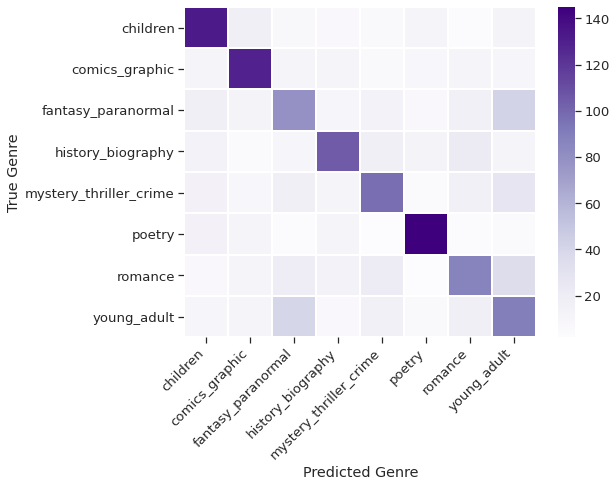

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap="Purples")    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, [id2label[l] for l in predicted_labels]):
  if _true_label != _predicted_label:
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

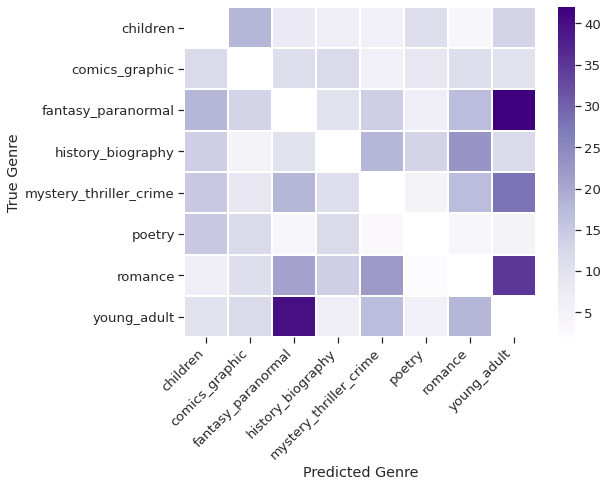

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap="Purples")    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There's much more you can do with your own dataset and labels! Classification can be used to apply a small set of labels across a big dataset; to explore misclassifications to better understand users; and much more! We hope you'll use this tutorial in all kinds of creative ways.